In [1]:
# load data from tsp file
import numpy as np

tsp_data = np.loadtxt('..\gr17.2085.tsp')
print(tsp_data.shape)

(17, 17)


In [2]:
tsp_data

array([[  0., 633., 257.,  91., 412., 150.,  80., 134., 259., 505., 353.,
        324.,  70., 211., 268., 246., 121.],
       [633.,   0., 390., 661., 227., 488., 572., 530., 555., 289., 282.,
        638., 567., 466., 420., 745., 518.],
       [257., 390.,   0., 228., 169., 112., 196., 154., 372., 262., 110.,
        437., 191.,  74.,  53., 472., 142.],
       [ 91., 661., 228.,   0., 383., 120.,  77., 105., 175., 476., 324.,
        240.,  27., 182., 239., 237.,  84.],
       [412., 227., 169., 383.,   0., 267., 351., 309., 338., 196.,  61.,
        421., 346., 243., 199., 528., 297.],
       [150., 488., 112., 120., 267.,   0.,  63.,  34., 264., 360., 208.,
        329.,  83., 105., 123., 364.,  35.],
       [ 80., 572., 196.,  77., 351.,  63.,   0.,  29., 232., 444., 292.,
        297.,  47., 150., 207., 332.,  29.],
       [134., 530., 154., 105., 309.,  34.,  29.,   0., 249., 402., 250.,
        314.,  68., 108., 165., 349.,  36.],
       [259., 555., 372., 175., 338., 264., 232.

In [3]:
import math
import queue

def pickneighbor(s):
    index = np.random.choice(range(17), 2, replace=False) # pick randomly 2 indices in [0,16]
    s[index[0]],s[index[1]] = s[index[1]],s[index[0]] # swap values located at these indices
    return s

def objectivefunction(s):
    cost = 0
    for i in range(s.shape[0]-1):
        cost = cost + tsp_data[s[i]][s[i+1]]
    
    cost = cost + tsp_data[s[-1]][s[0]]
    return cost

        
def pick_next_nontabu_neighbor(neighbors_list, tabu_list):
    index = 1
    while index < neighbors_list.shape[0]:
        neighbor = np.copy(neighbors_list[index])
        if not(tabu_neighbor(neighbor, tabu_list)):
            return neighbor
        index = index+1
             
def tabu_neighbor(s, tabu_list):
    
    for sol in tabu_list.queue:
        if((sol==s).all()):
            return True
        
    return False
        
def generate_sorted_neighbors(s):
    neighbors_list = []
    tmp_s = np.copy(s)
    for i in range(s.shape[0]-1):
        for j in range(i+1,s.shape[0]):
            tmp_s[i],tmp_s[j] = tmp_s[j],tmp_s[i] # swap values located at these indices
            neighbors_list.append(tmp_s)
            tmp_s = np.copy(s)
            
    costs = map(lambda x: objectivefunction(x), neighbors_list) # calculate costs of each neighbor
    
    costs = np.asarray(list(costs))
    indices = costs.argsort() # get sorted indices of costs
    
    neighbors_list = np.asarray(neighbors_list) 
    neighbors_list = neighbors_list[indices] # sort neighbors according to costs from min to max
    costs = costs[indices] #sort costs from min to max
    
    return neighbors_list, costs
        
def best_admessible_neighbor_v2(s,tabu_list):
    
    neighbors_list, costs = generate_sorted_neighbors(np.copy(s))
    best_neighbor, cost = neighbors_list[0], costs[0]
    
    tabu = tabu_neighbor(best_neighbor, tabu_list)
    if (cost<objectivefunction(s)):
        if tabu:
            return best_neighbor, True
        else:
            return best_neighbor, False
    else: # escape from local optimum by accepting a degraded solution
        if not(tabu):
            return best_neighbor, False
        else: #pick non tabu neighbor 
            return pick_next_nontabu_neighbor(neighbors_list, tabu_list), False
      

In [8]:
import queue
import matplotlib.pyplot as plt

tabu_list = queue.Queue(5) # FIFO queue of 5 items max

costs_hist = []


# random initial solution and its cost
s = np.random.choice(range(17), 17, replace=False) #cities in [0,16]
cost_s = objectivefunction(s)

# update tabu list
tabu_list.put(np.copy(s))

# save history of costs
costs_hist.append(cost_s)

# consider solution s as the best solution for now
best_s = np.copy(s) # hard copy
best_cost = cost_s

total_it = 0 # max iterations

while total_it < 100:
    adm_s, tabu = best_admessible_neighbor_v2(np.copy(s),tabu_list)
    cost_adm_s = objectivefunction(adm_s)
    costs_hist.append(cost_adm_s)
    
    # update s
    s = np.copy(adm_s)
    
    if (not(tabu)): # adm_s not satisfying an aspiration criterion
        
        if (best_cost > cost_adm_s): # update best sol if necessary
                best_s = np.copy(adm_s) # update best solution
                best_cost = cost_adm_s
        
        # update tabu list by adding adm_s as a visited solution
        if not(tabu_list.full()): 
            tabu_list.put(np.copy(adm_s))
        else:
            tabu_list.get() # get an item to free a place
            tabu_list.put(np.copy(adm_s))
            
    total_it = total_it+1
        
    

    
print ('best sol, cost {} {}'.format(best_s,best_cost))

best sol, cost [14  2 13 16  5  7  6 12  3  0 15 11  8 10  4  1  9] 2153.0


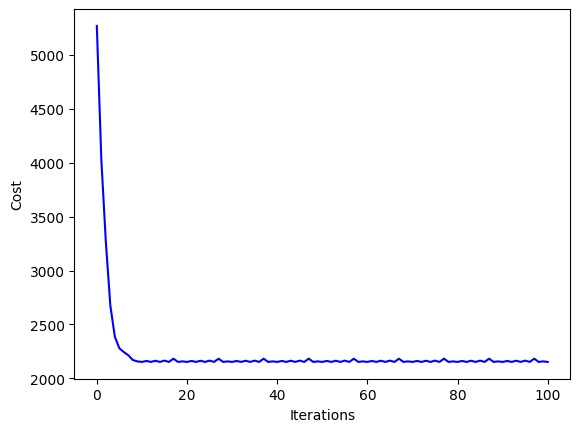

In [9]:
import matplotlib.pyplot as plt

plt.plot(costs_hist, 'b')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

C:\Users\steph\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
C:\Users\steph\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


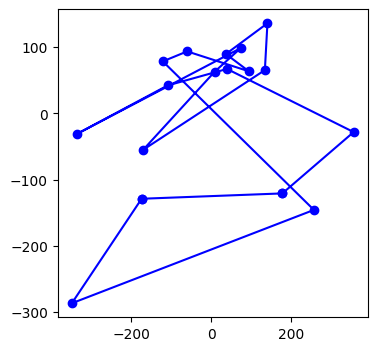

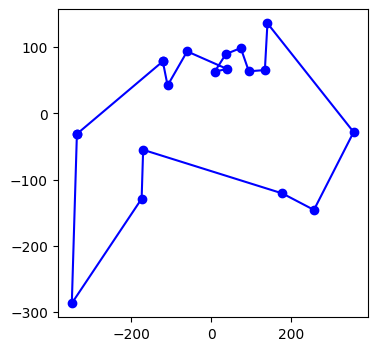

In [10]:
# convert distance matrix between cities into coordinates of cities 
from sklearn import manifold  # multidimensional scaling

mds_model = manifold.MDS(n_components=2, random_state=17,
                             dissimilarity='precomputed')
mds_fit = mds_model.fit(tsp_data)
mds_coords = mds_model.fit_transform(tsp_data)

# plot a random solution over cities
s = np.random.choice(range(17), 17, replace=False)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(mds_coords[s, 0], mds_coords[s, 1], 'b-o')
plt.plot([mds_coords[s[0], 0], mds_coords[s[-1], 0]],
         [mds_coords[s[0], 1], mds_coords[s[-1], 1]], 'b-o')


# plot the best solution over cities
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(mds_coords[best_s, 0], mds_coords[best_s, 1], 'b-o')
plt.plot([mds_coords[best_s[0], 0], mds_coords[best_s[-1], 0]],
         [mds_coords[best_s[0], 1], mds_coords[best_s[-1], 1]], 'b-o')